<a href="https://colab.research.google.com/github/macrae/comics-net/blob/master/Copy_of_fastai_entityRemoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Comic Book Cover Restoration?

Image restoration is the process of restoring the original image from the distorted one. Image restoration is of various kinds like:

- take a low-resolution image and convert it to the high-resolution image
- convert the black and white image to the coloured image
- restore the broken part of the image

We will focus this research spike on restoring the broken part of the image.

In [0]:
import fastai
import pathlib
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from PIL import Image, ImageDraw, ImageFont

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = pathlib.Path.cwd()
# path_hr = path/'gdrive/My Drive/covers/justice_league/images'
# path_lr = path/'gdrive/My Drive/covers/justice_league/crappy'

In [7]:
path/'gdrive/My Drive/covers/'

PosixPath('/content/gdrive/My Drive/covers')

In [0]:
# !rm -rf "/content/images"

In [0]:
 !cp -rf "/content/gdrive/My Drive/covers" "/content/covers"

In [12]:
!tar -xvf "/content/covers/justice_league/images.tar.gz" -C "/content/covers/justice_league"

Streaming output truncated to the last 5000 lines.
images/Green Arrow: Green Arrow #4 Original (1988-01-19).jpg
images/._Green Lantern: Green Lantern #44 Original (1966-02-22).jpg
images/Green Lantern: Green Lantern #44 Original (1966-02-22).jpg
images/._Batman: Batman #339 British (1981-05-12).jpg
images/Batman: Batman #339 British (1981-05-12).jpg
images/._Detective Comics: Detective Comics #234 Original (1956-06-24).jpg
images/Detective Comics: Detective Comics #234 Original (1956-06-24).jpg
images/._Batman: Journey into Knight: Batman: Journey into Knight #12 Original (2006-09-27).jpg
images/Batman: Journey into Knight: Batman: Journey into Knight #12 Original (2006-09-27).jpg
images/._Superman: Superman #128 Original (1959-02-05).jpg
images/Superman: Superman #128 Original (1959-02-05).jpg
images/._The Flash: The Flash #8 Original (2012-04-25).jpg
images/The Flash: The Flash #8 Original (2012-04-25).jpg
images/._Detective Comics: Detective Comics #52 Original (1941-04-30).jpg
imag

In [0]:
path = pathlib.Path.cwd()
path_hr = path/'covers/justice_league/images'
path_lr = path/'covers/justice_league/crappy'

In [0]:
class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr
    def __call__(self, fn, i):
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img_open = PIL.Image.open(fn)
        targ_sz = resize_to(img_open, 96, use_min=True)
        img = img_open.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.\
          Draw(img).\
          text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

Memorize one thing, anything you do not include in the crappifier() , the model won’t learn to fix that.

The process to crappify the images can take a while, but fast.ai has a function called parallel. If you pass parallel a function name and a list of things to run that function on, it will run that function on them all in parallel. So, it will save a lot of time.

In [16]:
crappify = crappifier(path_lr, path_hr)

il = ImageList.from_folder(path_hr)
parallel(crappify, il.items)

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

bs, size = 32, (600//6, 400//6)
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
               .transform(size=size, tfm_y=True)
               .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    
    return data

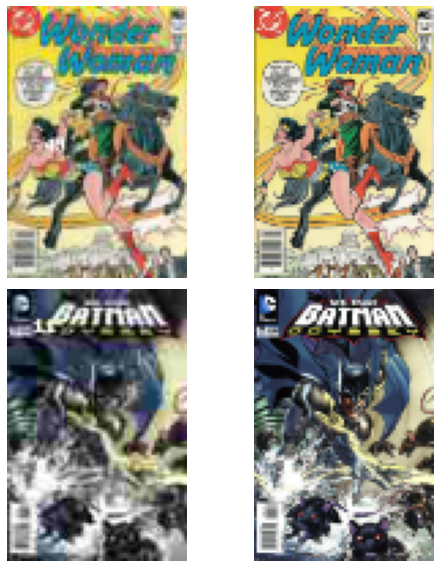

In [18]:
data_gen = get_data(bs,size)
data_gen.show_batch(2)

In [19]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()
def create_gen_learner():
    return unet_learner(data_gen,
                        arch, wd=wd,
                        blur=True,
                        norm_type=NormType.Weight,
                        self_attention=True,
                        y_range=y_range,
                        loss_func=loss_gen)

learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [20]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.119999,0.115354,01:43
1,0.099518,0.097816,01:43


epoch,train_loss,valid_loss,time
0,0.096583,0.094847,01:44
1,0.092838,0.091496,01:44
2,0.091343,0.090410,01:44


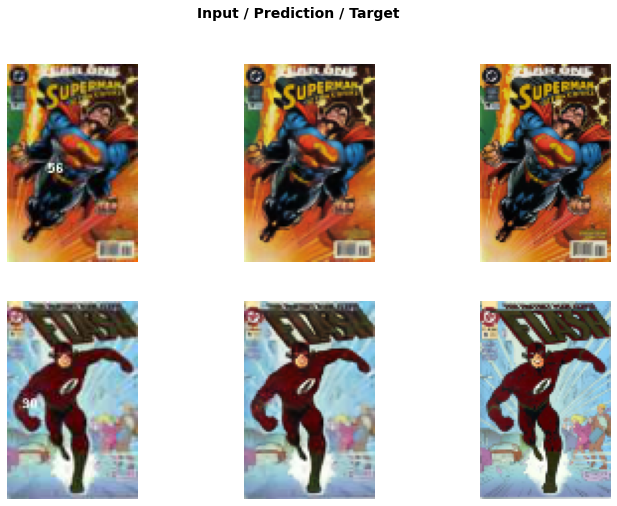

In [21]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))
learn_gen.show_results(rows=2)

In [0]:
name_gen = "covers/justice_league/image_gen"
path_gen = path/name_gen
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

save_preds(data_gen.fix_dl)

In [27]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes)\
                   .split_by_rand_pct(0.1, seed=42)
  
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
              .databunch(bs=bs).normalize(imagenet_stats))
    return data

data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:458: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


Exception: ignored